In [1]:
#Import Lib
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

from tensorflow.keras.layers import Dense, LSTM, RNN, Embedding, Dropout
from tensorflow.keras.models import Sequential

from keras.backend import clear_session

import os

In [2]:
df = pd.read_csv(r'D:/Users/Desktop/Scientific-research/Deep learning/Data/NSL-KDD/KDDTrain+.txt')

In [3]:
df.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [4]:
#Define Data
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                      'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                      'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                      'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                      'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                      'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']


cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']

In [5]:
#Pretrain dataset
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [6]:
def Scaling(df_num, cols):
    std_scaler = MinMaxScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

In [7]:
scaled_train = preprocess(df)

X = scaled_train.drop(['outcome', 'level'], axis=1).values
y = scaled_train['outcome'].values

#Reduce dim
pca = PCA(n_components=20)
pca = pca.fit(X)
X_reduced = pca.transform(X)

# Convert labels to integers
y = y.astype('int')

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [8]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile models
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit model
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=10, batch_size=32,
                    validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test))

Epoch 1/10
3150/3150 [==============================] - 30s 8ms/step - loss: 0.1643 - accuracy: 0.9386 - val_loss: 0.1406 - val_accuracy: 0.9493
Epoch 2/10
3150/3150 [==============================] - 25s 8ms/step - loss: 0.1249 - accuracy: 0.9584 - val_loss: 0.1112 - val_accuracy: 0.9646
Epoch 3/10
3150/3150 [==============================] - 26s 8ms/step - loss: 0.1069 - accuracy: 0.9642 - val_loss: 0.0857 - val_accuracy: 0.9647
Epoch 4/10
3150/3150 [==============================] - 24s 8ms/step - loss: 0.0897 - accuracy: 0.9642 - val_loss: 0.0898 - val_accuracy: 0.9598
Epoch 5/10
3150/3150 [==============================] - 24s 8ms/step - loss: 0.0850 - accuracy: 0.9660 - val_loss: 0.0785 - val_accuracy: 0.9674
Epoch 6/10
3150/3150 [==============================] - 26s 8ms/step - loss: 0.0772 - accuracy: 0.9692 - val_loss: 0.0770 - val_accuracy: 0.9690
Epoch 7/10
3150/3150 [==============================] - 27s 8ms/step - loss: 0.0722 - accuracy: 0.9719 - val_loss: 0.0736 - val_ac

In [10]:
# Predicted values
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = (y_pred > 0.5)

print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

788/788 [==============================] - 2s 2ms/step
Confusion matrix: [[13254   132]
 [  402 11407]]
Accuracy: 0.9788053185155785
Precision: 0.988560533841754
Recall: 0.9659581674993649
F1 Score: 0.9771286619838958


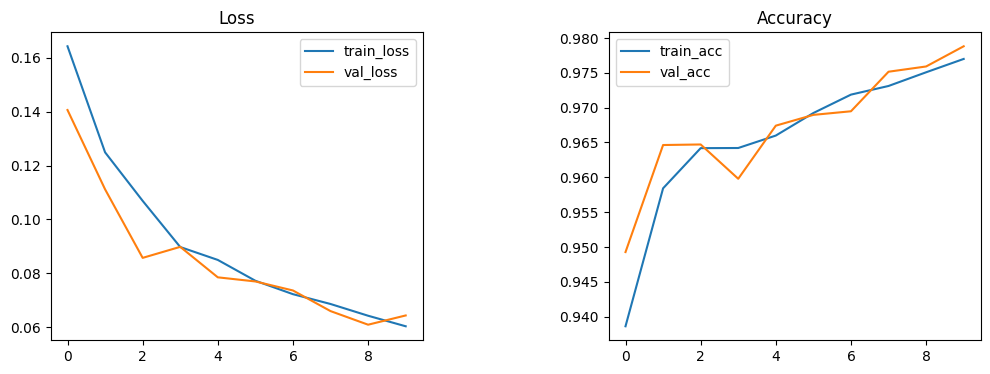

In [11]:
# Draw chart
import matplotlib.pyplot as plt

# Lấy ra các giá trị loss và accuracy từ history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Vẽ biểu đồ
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].plot(train_loss, label='train_loss')
ax[0].plot(val_loss, label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='train_acc')
ax[1].plot(val_acc, label='val_acc')
ax[1].set_title('Accuracy')
ax[1].legend()

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.5)

plt.show()

In [12]:
## Ta có thể thấy model hoạt động khá tốt và không bị overfitting